In [ ]:
  # This Cell adds model estimate as a column of Data
model = None
df2 = pd.read_csv("U:/ML_project/bargh/data/processed/integrated.csv", encoding='utf-8')
df2.loc[~df2['status'].isin(['SO', 'LF1']), 'status'] = 'SO'
df2.loc[~df2['value'].isin(['P']), 'value'] = 'P'
df2.drop(columns=feature_to_be_dropped, axis=1, inplace=True)

categorical_cols = df2.select_dtypes(include=['object', 'category']).columns
df2 = pd.get_dummies(df2, columns=categorical_cols, drop_first=True)

X_all = df2.drop(columns=["generation"])
y_all = df2["generation"]

y_pred = model.pred(X_all)
df3 = pd.read_csv("U:/ML_project/bargh/data/processed/integrated.csv", encoding='utf-8')
df3['prediction'] = y_pred
df3.to_csv('U:/ML_project/bargh/data/processed/with_prediction.csv', index=False)

In [ ]:
import sys, os

project_root = "U:/ML_project/bargh"
sys.path.insert(0, project_root)

import pandas as pd
from data_selector import Data_selector
from feature_modifier import Feature_selector, Feature_adder
from logs.logger import CustomLogger
from models import Random_Forest, Linear, Polynomial, XGBoost

logger = CustomLogger(name="model_main", log_file_name='model_main.log').get_logger()

if __name__ == "__main__":
    csv_path = os.path.join(project_root, "data", "processed", "integrated.csv")
df = pd.read_csv(csv_path, encoding='utf-8')
logger.info(f"Csv file has bean read successfully")

feature_adder = Feature_adder(df)
feature_adder.add_season()
feature_adder.create_feature_with_delay("temperature", 1)
feature_adder.create_feature_with_delay("temperature", 2)
feature_adder.create_feature_with_delay("temperature", 3)
feature_adder.create_feature_with_delay("generation", 1)
feature_adder.create_feature_with_delay("generation", 2)
feature_adder.create_feature_with_delay("generation", 3)
feature_adder.create_feature_with_delay("generation", 24)

logger.info(f"Some features have been added successfully")

data_selector = Data_selector(feature_adder.df)
df_modified = data_selector.select(m_in_summer=True)
logger.info(f"Rows have been selected successfully")
feature_selector = Feature_selector(df_modified, "generation")
feature_to_be_dropped = ['id', 'date', 'declare', 'require']
X, y = feature_selector.select(feature_to_be_dropped)
logger.info(f"Some features have been dropped successfully")



In [ ]:
    import seaborn as sns
import matplotlib.pyplot as plt

df_numeric = df_modified.select_dtypes(include=['number'])
correlation_matrix = df_numeric.corr()

In [ ]:
    plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
    # Check features importance:

from models import XGBoost
import xgboost as xgb
import shap

xgb_model = XGBoost()
xgb_model.scale_and_split_data(X, y)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(xgb_model.X_train, xgb_model.y_train)
xgb_model.model = model

columns = list(feature_selector.df.columns)
columns.remove("generation")
X_test_df = pd.DataFrame(xgb_model.X_test, columns=columns)

explainer = shap.Explainer(model)

shap_values = explainer(X_test_df)

shap.summary_plot(shap_values, X_test_df, max_display=60)


In [1]:
import sys, os

project_root = "U:/ML_project/bargh"
sys.path.insert(0, project_root)

import pandas as pd
from data_selector import Data_selector
from feature_modifier import Feature_selector, Feature_adder
from logs.logger import CustomLogger
from models import Random_Forest, Linear, Polynomial, XGBoost

logger = CustomLogger(name="model_main", log_file_name='model_main.log').get_logger()

if __name__ == "__main__":
    csv_path = os.path.join(project_root, "data", "processed", "integrated.csv")
df = pd.read_csv(csv_path, encoding='utf-8')
logger.info(f"Csv file has bean read successfully")

feature_adder = Feature_adder(df)
feature_adder.add_season()
feature_adder.create_feature_with_delay("temperature", 3)
feature_adder.create_feature_with_delay("generation", 24)
logger.info(f"Some features have been added successfully")

data_selector = Data_selector(feature_adder.df)
df_modified = data_selector.select(m_in_summer=True)
logger.info(f"Rows have been selected successfully")

feature_selector = Feature_selector(df_modified, "generation")
feature_to_be_dropped = ['id', 'date', 'declare', 'require']
less_important_feature = ['dew', 'apparent_temperature', 'precipitation', 'rain', 'snow',
                          'evapotransporation', 'wind_speed', 'wind_direction']
X, y = feature_selector.select(feature_to_be_dropped + less_important_feature)
logger.info(f"Some features have been dropped successfully")

# n_est = 100
# depth = 30
# model = Random_Forest()
# model.scale_and_split_data(X, y)
# model.fit(n_estimators=n_est, max_depth=depth)

# model = Linear()
# model.scale_and_split_data(X, y)
# model.fit()

# model = Polynomial()
# model.scale_and_split_data(X, y)
# model.fit()

n_est = 100
depth = 5
model = XGBoost()
model.scale_and_split_data(X, y)
model.fit(n_estimators=n_est, max_depth=depth)

logger.info(f"Model has been trained successfully")

rmse_error_train, rmse_error_test = model.compute_rmse_error()
print(f"Train Error: {rmse_error_train:0.2f}%, Test Error: {rmse_error_test:0.2f}%")


2025-08-19 14:35:59 - model_main - INFO - Csv file has bean read successfully
2025-08-19 14:36:02 - model_main - INFO - Some features have been added successfully
2025-08-19 14:36:02 - model_main - INFO - Rows have been selected successfully
2025-08-19 14:36:03 - model_main - INFO - Some features have been dropped successfully
2025-08-19 14:36:06 - model_main - INFO - Model has been trained successfully


Train Error: 7.42%, Test Error: 7.55%


In [2]:
project_root = "U:/ML_project/bargh"
csv_path = os.path.join(project_root, "data", "processed", "integrated.csv")
df = pd.read_csv(csv_path, encoding='utf-8')
df['date'] = pd.to_datetime(df['date'])
df['datetime'] = df['date'] + pd.to_timedelta(df['hour'], unit='h')
df = df.sort_values(by=['code', 'name', 'date', 'hour'])

feature_to_be_dropped = ['id', 'date', 'declare', 'require', 'datetime']
less_important_feature = ['dew', 'apparent_temperature', 'precipitation', 'rain', 'snow',
                          'evapotransporation', 'wind_speed', 'wind_direction']

df = df.drop(feature_to_be_dropped + less_important_feature, axis=1)

n_rows = 24
n_cols = df.shape[1]

arr = df.to_numpy()

new_rows = df.shape[0] // n_rows

reshaped = arr[:new_rows * n_rows].reshape(new_rows, n_rows * n_cols)

new_columns = []
for i in range(n_rows):
    for col in df.columns:
        new_columns.append(f"{col}_{i+1}")

new_df = pd.DataFrame(reshaped, columns=new_columns)

In [3]:
to_be_dropped_columns = []
for col in ['name', 'code', 'hour']:
    for i in range(24):
        col_name = f"{col}_{i+1}"
        if col_name in ['name_1', 'code_1']: continue
        to_be_dropped_columns.append(col_name)
        
common_deleted_df = new_df.drop(to_be_dropped_columns, axis=1)

categorical_cols = ['name_1', 'code_1'] + [f'value_{i+1}' for i in range(24)] + [f'status_{i+1}' for i in range(24)]
final_df = pd.get_dummies(common_deleted_df, columns=categorical_cols, drop_first=True)

final_df = final_df.dropna()


In [4]:
len(final_df.columns)

1376

In [5]:
generation_columns = [f"generation_{i+1}" for i in range(24)]
X = final_df.drop(columns=generation_columns)
y = final_df[generation_columns]
        

In [11]:
X.shape

(34728, 1352)

In [12]:
from models import Model
group_model = Model()
group_model.scale_and_split_data(X, y, y_is_flat=False)

In [15]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.1,
    objective='reg:squarederror'
)

multi_model = MultiOutputRegressor(xgb_model)

multi_model.fit(group_model.X_train, group_model.y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,n_jobs,None
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None


In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np
y_pred_test = multi_model.predict(group_model.X_test)
y_pred_train = multi_model.predict(group_model.X_train)
y_pred_test_actual = group_model.scaler_y.inverse_transform(y_pred_test).ravel()
y_pred_train_actual = group_model.scaler_y.inverse_transform(y_pred_train).ravel()
y_test_actual = group_model.scaler_y.inverse_transform(group_model.y_test).ravel()
y_train_actual = group_model.scaler_y.inverse_transform(group_model.y_train).ravel()

rmse_test_actual = (mean_squared_error(y_test_actual, y_pred_test_actual) ** 0.5 / np.mean(y_test_actual)) * 100
rmse_train_actual = (mean_squared_error(y_train_actual, y_pred_train_actual) ** 0.5 / np.mean(y_train_actual)) * 100

print(f"Train Error: {rmse_train_actual:0.2f}%, Test Error: {rmse_test_actual:0.2f}%")


Train Error: 1.24%, Test Error: 11.11%


In [81]:
import os
import pandas as pd
from prophet import Prophet
from data_selector import Data_selector
from feature_modifier import Feature_selector, Feature_adder
from logs.logger import CustomLogger

project_root = "U:/ML_project/bargh"

logger = CustomLogger(name="jas_test", log_file_name='jas_tes.log').get_logger()

csv_path = os.path.join(project_root, "data", "processed", "integrated.csv")
df = pd.read_csv(csv_path, encoding='utf-8')
df['date'] = pd.to_datetime(df['date'])
df['ds'] = df['date'] + pd.to_timedelta(df['hour'], unit='h')
df = df.rename(columns={"generation": "y"})
logger.info(f"Csv file has bean read successfully")

feature_adder = Feature_adder(df)
feature_adder.add_season()
feature_adder.create_feature_with_delay("temperature", 3)
feature_adder.create_feature_with_delay("y", 24)
logger.info(f"Some features have been added successfully")

data_selector = Data_selector(feature_adder.df)
data_selector.select_name_and_code("سبلان", "G11")
df_modified = data_selector.select_peaks(m_in_summer=True)
logger.info(f"Rows have been selected successfully")

feature_selector = Feature_selector(df_modified, target="y")
feature_to_be_dropped = ['id', 'date', 'declare', 'require']
less_important_feature = ['dew', 'apparent_temperature', 'precipitation', 'rain', 'snow',
                          'evapotransporation', 'wind_speed', 'wind_direction']

feature_selector.select(feature_to_be_dropped + less_important_feature)
preprocessed_df = feature_selector.df
logger.info(f"Some features have been dropped successfully")


2025-08-20 16:16:24 - jas_test - INFO - Csv file has bean read successfully
2025-08-20 16:16:26 - jas_test - INFO - Some features have been added successfully
2025-08-20 16:16:26 - jas_test - INFO - Rows have been selected successfully
2025-08-20 16:16:27 - jas_test - INFO - Some features have been dropped successfully


In [82]:
preprocessed_df.shape


(9317, 14)

In [83]:
preprocessed_df.head()

,hour,temperature,humidity,surface_pressure,forecast,y,ds,temperature_with_3_delay,y_with_24_delay,value_P,status_SO,season_spring,season_summer,season_winter
4417,21,11.009,64.0,853.39557,33207,100.522573,2021-03-23 21:00:00,12.509,105.672519,True,True,True,False,False
4418,22,10.209,69.0,852.58790,33002,97.539882,2021-03-23 22:00:00,11.609,121.244953,True,True,True,False,False
5968,21,10.209,46.0,851.05646,33967,117.904768,2021-03-24 21:00:00,12.709,100.522573,True,True,True,False,False
5969,22,8.909,50.0,851.28270,33807,118.250199,2021-03-24 22:00:00,11.509,97.539882,True,True,True,False,False
7124,21,6.109,50.0,858.74760,34647,116.642298,2021-03-25 21:00:00,8.309,117.904768,True,True,True,False,False


In [84]:
preprocessed_df.columns

Index(['hour', 'temperature', 'humidity', 'surface_pressure', 'forecast', 'y',
       'ds', 'temperature_with_3_delay', 'y_with_24_delay', 'value_P',
       'status_SO', 'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [85]:
train_df = preprocessed_df.iloc[:-240]
test_df = preprocessed_df.iloc[-240:]

model = Prophet()
for col in preprocessed_df.columns:
    if col in ['ds', 'y']: continue
    model.add_regressor(col)
model.fit(train_df)


16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
future = test_df.drop(columns=['y'])
forecast = model.predict(future)


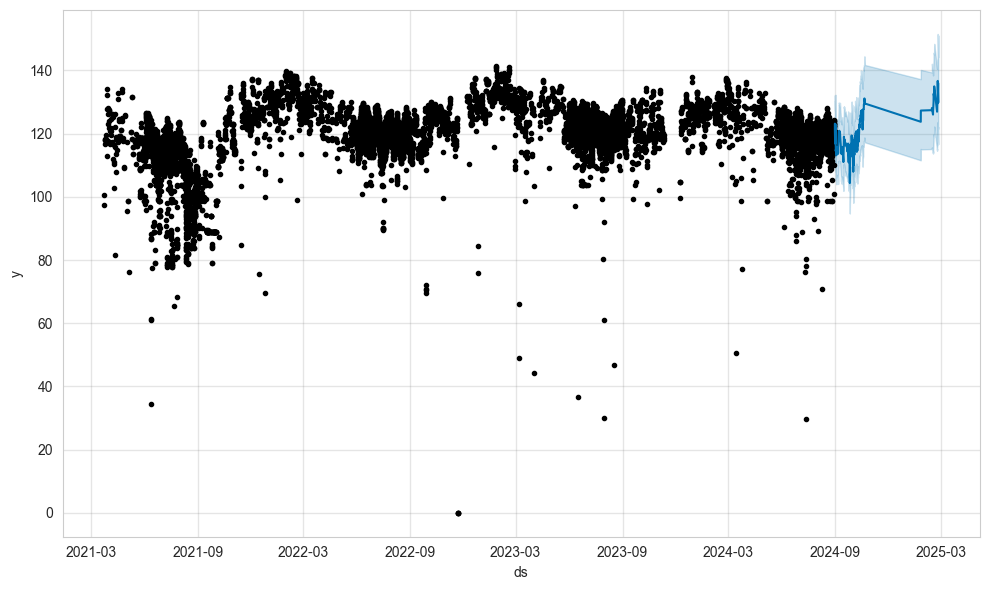

In [87]:
import matplotlib.pyplot as plt

model.plot(forecast)
plt.show()


In [88]:
y_true = test_df['y'].values
y_pred = forecast['yhat'].values

In [89]:
import numpy as np
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true) * 100
print(f"Test Error: {rmse:0.2f}%")

Test Error: 10.31%
